Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 with 27626 time steps
CFL ratio: 1.0000 (should be <= 1.0)
Grid setup complete: 501 spatial points, 27627 time points
S range: [90, 110], dS: 0.0400
T range: [0, 0.0822], dt: 0.0000029752

Terminal condition (payoff at expiration):
Min: -5.000000, Max: 0.000000
Sample @ S=100,100,100: 0.000000,0.000000,0.000000

Tridiagonal matrix coefficients at middle grid:
a[250]: 0.371709, b[250]: 1.743790, c[250]: 0.372081

At step 27620, t=0.082174:
Max diff: 4.876506e-03, Put pts: 114.0, Call pts: 127.0
Put boundary: S=95.4400
Call boundary: S=104.6400

At step 24858, t=0.073957:
Max diff: 1.185794e-03, Put pts: 7.0, Call pts: 7.0
Put boundary: S=104.0000
Call boundary: S=95.0400

At step 22096, t=0.065739:
Max diff: 5.112598e-03, Put pts: 5.0, Call pts: 6.0
Put boundary: S=90.0000
Call boundary: S=110.0000

At step 19334, t=0.057522:
Max diff: 7.609600e-03, Put pts: 4.0, Call pts: 5.0
Put boundary: S=90.0000
Call boundary: S=110.0000

At st

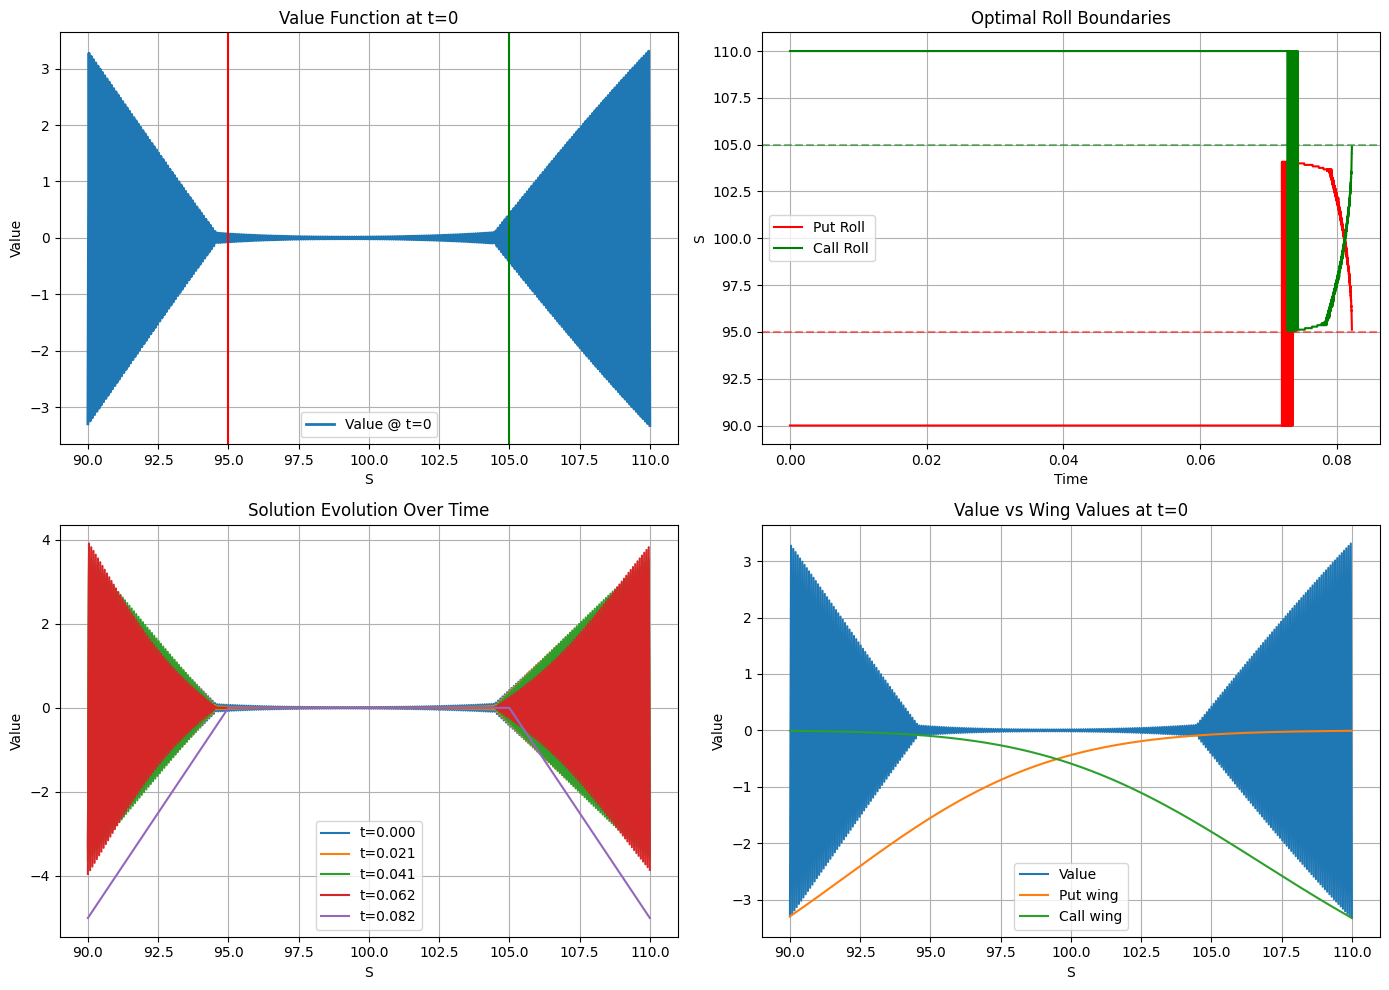

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time
import math
from numba import njit, prange

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return S * _cdf(d1) - K * math.exp(-r * tau) * _cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return K * math.exp(-r * tau) * _cdf(-d2) - S * _cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) + bs_put_numba(S, Kp_long, r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) + bs_call_numba(S, Kc_long, r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t, Kp_long, Kp_short, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

# --- Main class -------------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        # Market & option params
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long, self.Kp_short = K_put_long, K_put_short
        self.Kc_short, self.Kc_long = K_call_short, K_call_long

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns, self.Nt    = Ns, Nt
        self.dS = (S_max - S_min) / Ns
        # CFL-based dt
        dt_max = 0.9 * (self.dS**2) / (self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T / Nt, dt_max)
        self.Nt = int(self.T / self.dt) + 1
        self.dt = self.T / self.Nt
        print(f"Using dt: {self.dt:.10f} with {self.Nt} time steps")
        print(f"CFL ratio: {self.dt/dt_max:.4f} (should be <= 1.0)")

        # grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        # initialize arrays
        self.J = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)
        print(f"Grid setup complete: {Ns+1} spatial points, {self.Nt+1} time points")
        print(f"S range: [{S_min}, {S_max}], dS: {self.dS:.4f}")
        print(f"T range: [0, {self.T:.4f}], dt: {self.dt:.10f}")

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0, 1:] = c[:-1]
        ab[1, :]  = b
        ab[2, :-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            alpha = 0.5 * self.sigma**2 * S**2 / self.dS**2
            beta  =     self.r       * S      / (2*self.dS)
            a[i] = self.dt * (alpha - beta)
            b[i] = 1 + self.dt * (2*alpha + self.r)
            c[i] = self.dt * (alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def solve(self):
        start_time = time.time()
        # terminal condition
        for i, S in enumerate(self.S_grid):
            self.J[-1, i] = iron_condor_payoff_numba(
                S, self.T,
                self.Kp_long, self.Kp_short,
                self.Kc_short, self.Kc_long,
                self.r, self.sigma, self.T)
        # print terminal
        print("\nTerminal condition (payoff at expiration):")
        print(f"Min: {np.min(self.J[-1]):.6f}, Max: {np.max(self.J[-1]):.6f}")
        mid = self.Ns//2
        print(f"Sample @ S={self.S_grid[mid-10]:.0f},{self.S_grid[mid]:.0f},{self.S_grid[mid+10]:.0f}: "
              f"{self.J[-1,mid-10]:.6f},{self.J[-1,mid]:.6f},{self.J[-1,mid+10]:.6f}")

        # build matrix coeffs
        a, b, c = self.build_coeffs()
        print("\nTridiagonal matrix coefficients at middle grid:")
        print(f"a[{mid}]: {a[mid]:.6f}, b[{mid}]: {b[mid]:.6f}, c[{mid}]: {c[mid]:.6f}")

        max_diff = np.zeros(self.Nt)
        num_put = np.zeros(self.Nt)
        num_call= np.zeros(self.Nt)

        # backward time solve
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            d = self.J[n+1].copy()
            # boundaries
            d[0]      = iron_condor_payoff_numba(self.S_min, t,
                             self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
            d[-1]     = iron_condor_payoff_numba(self.S_max, t,
                             self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
            # solve
            J_cont = self._solve_tridiagonal(a, b, c, d)
            self.J[n] = J_cont
            # check rolls
            put_idx=[]; call_idx=[]
            for i, S in enumerate(self.S_grid):
                if S < self.Kp_short*1.1:
                    valp = challenged_put_numba(S, t,
                             self.Kp_long,self.Kp_short,
                             self.r,self.sigma,self.T)
                    if valp > J_cont[i]:
                        self.J[n,i]=valp; put_idx.append(i)
                if S > self.Kc_short*0.9:
                    valc = challenged_call_numba(S, t,
                             self.Kc_short,self.Kc_long,
                             self.r,self.sigma,self.T)
                    if valc > J_cont[i]:
                        self.J[n,i]=valc; call_idx.append(i)
            num_put[n]=len(put_idx); num_call[n]=len(call_idx)
            if put_idx:  self.roll_put[n]  = self.S_grid[min(put_idx)]
            if call_idx: self.roll_call[n] = self.S_grid[max(call_idx)]
            max_diff[n]=np.max(np.abs(self.J[n]-J_cont))
            # diagnostics every 10%
            if n % max(1,self.Nt//10)==0:
                print(f"\nAt step {n}, t={t:.6f}:")
                print(f"Max diff: {max_diff[n]:.6e}, Put pts: {num_put[n]}, Call pts: {num_call[n]}")
                if not np.isnan(self.roll_put[n]):  print(f"Put boundary: S={self.roll_put[n]:.4f}")
                if not np.isnan(self.roll_call[n]): print(f"Call boundary: S={self.roll_call[n]:.4f}")

        end_time=time.time()
        print(f"\nSolution completed in {end_time-start_time:.2f} seconds")
        print(f"Maximum value difference: {np.max(max_diff):.6e}")
        # final stats
        V0 = np.interp(self.S0, self.S_grid, self.J[0])
        print(f"\nValue @ t=0, S0={self.S0}: {V0:.6f}")
        if not np.isnan(self.roll_put[0]):  print(f"Initial put boundary: S={self.roll_put[0]:.4f}")
        if not np.isnan(self.roll_call[0]): print(f"Initial call boundary: S={self.roll_call[0]:.4f}")

    def plot_results(self):
        fig, axes = plt.subplots(2,2,figsize=(14,10))
        # value @ t=0
        ax=axes[0,0]
        ax.plot(self.S_grid,self.J[0],lw=2,label='Value @ t=0')
        ax.axvline(self.Kp_short, color='r',ls='-')
        ax.axvline(self.Kc_short, color='g',ls='-')
        ax.set(title='Value Function at t=0',xlabel='S',ylabel='Value')
        ax.grid(True); ax.legend()
        # roll boundaries
        ax=axes[0,1]
        vp=~np.isnan(self.roll_put); vc=~np.isnan(self.roll_call)
        if vp.any(): ax.plot(self.t_grid[vp],self.roll_put[vp],'r-',label='Put Roll')
        if vc.any(): ax.plot(self.t_grid[vc],self.roll_call[vc],'g-',label='Call Roll')
        ax.axhline(self.Kp_short,color='r',ls='--',alpha=0.5)
        ax.axhline(self.Kc_short,color='g',ls='--',alpha=0.5)
        ax.set(title='Optimal Roll Boundaries',xlabel='Time',ylabel='S')
        ax.grid(True); ax.legend()
        # evolution
        ax=axes[1,0]
        for idx in [0,self.Nt//4,self.Nt//2,3*self.Nt//4,self.Nt]:
            ax.plot(self.S_grid,self.J[idx],label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution Over Time',xlabel='S',ylabel='Value')
        ax.grid(True); ax.legend()
        # wing vs
        ax=axes[1,1]
        putv=np.array([challenged_put_numba(S,0.0,self.Kp_long,self.Kp_short,self.r,self.sigma,self.T) for S in self.S_grid])
        callv=np.array([challenged_call_numba(S,0.0,self.Kc_short,self.Kc_long,self.r,self.sigma,self.T) for S in self.S_grid])
        ax.plot(self.S_grid,self.J[0],label='Value'); ax.plot(self.S_grid,putv,label='Put wing'); ax.plot(self.S_grid,callv,label='Call wing')
        ax.set(title='Value vs Wing Values at t=0',xlabel='S',ylabel='Value')
        ax.grid(True); ax.legend()
        plt.tight_layout(); plt.show()

if __name__ =="__main__":
    # example
    S0,r,sigma,T=100,0.05,0.2,30/365.0
    Kp_long,Kp_short=90,95; Kc_short,Kc_long=105,110
    solver=IronCondorOptimalRoll(S0,r,sigma,T,Kp_long,Kp_short,Kc_short,Kc_long)
    solver.setup_grid(90,110,500,200)
    solver.solve()
    solver.plot_results()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time
import math
from numba import njit

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return S * _cdf(d1) - K * math.exp(-r * tau) * _cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return K * math.exp(-r * tau) * _cdf(-d2) - S * _cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) + bs_put_numba(S, Kp_long, r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) + bs_call_numba(S, Kc_long, r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t, Kp_long, Kp_short, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

@njit
def determine_challenged_wing_numba(S, Kp_short, Kc_short):
    if abs(S - Kp_short) < abs(S - Kc_short):
        return 0  # put
    else:
        return 1  # call

# --- Main class -------------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long, self.Kp_short = K_put_long, K_put_short
        self.Kc_short, self.Kc_long = K_call_short, K_call_long
        # argument tuples for numba calls
        self._args_payoff = (self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
        self._args_put    = (self.Kp_long, self.Kp_short,
                             self.r, self.sigma, self.T)
        self._args_call   = (self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns, self.Nt        = Ns, Nt
        self.dS = (S_max - S_min) / Ns
        # CFL-based dt
        dt_max = 0.9 * (self.dS**2) / (self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T / Nt, dt_max)
        self.Nt = int(self.T / self.dt) + 1
        self.dt = self.T / self.Nt
        print(f"Using dt: {self.dt:.10f} with {self.Nt} time steps")
        print(f"CFL ratio: {self.dt/dt_max:.4f} (should be <= 1.0)")
        # grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)
        # initialize arrays
        self.J         = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)
        print(f"Grid setup complete: {Ns+1} spatial points, {self.Nt+1} time points")

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            alpha = 0.5 * self.sigma**2 * S**2 / self.dS**2
            beta  =     self.r       * S      / (2*self.dS)
            a[i] = self.dt * (alpha - beta)
            b[i] = 1 + self.dt * (2*alpha + self.r)
            c[i] = self.dt * (alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0, 1:] = c[:-1]
        ab[1, :]  = b
        ab[2, :-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def solve(self):
        start_time = time.time()
        # terminal condition
        for i, S in enumerate(self.S_grid):
            self.J[-1, i] = iron_condor_payoff_numba(
                S, self.T, *self._args_payoff)
        a, b, c = self.build_coeffs()
        max_diff = np.zeros(self.Nt)
        num_put  = np.zeros(self.Nt)
        num_call = np.zeros(self.Nt)
        # backward in time
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            d = self.J[n+1].copy()
            # boundaries
            d[0]  = iron_condor_payoff_numba(self.S_min, t, *self._args_payoff)
            d[-1] = iron_condor_payoff_numba(self.S_max, t, *self._args_payoff)
            # implicit solve
            J_cont = self._solve_tridiagonal(a, b, c, d)
            self.J[n] = J_cont
            # single-wing roll
            put_idx = []
            call_idx= []
            for i, S in enumerate(self.S_grid):
                wing = determine_challenged_wing_numba(S, self.Kp_short, self.Kc_short)
                if wing == 0:  # put
                    val = challenged_put_numba(S, t, *self._args_put)
                    if val > J_cont[i]:
                        self.J[n, i] = val
                        put_idx.append(i)
                else:          # call
                    val = challenged_call_numba(S, t, *self._args_call)
                    if val > J_cont[i]:
                        self.J[n, i] = val
                        call_idx.append(i)
            num_put[n]  = len(put_idx)
            num_call[n] = len(call_idx)
            if put_idx:   self.roll_put[n]  = self.S_grid[min(put_idx)]
            if call_idx:  self.roll_call[n] = self.S_grid[max(call_idx)]
            max_diff[n]  = np.max(np.abs(self.J[n] - J_cont))
        print(f"Solution completed in {time.time()-start_time:.2f}s")

    def plot_results(self):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        # Value @ t=0
        ax = axes[0, 0]
        ax.plot(self.S_grid, self.J[0], lw=2, label='Value @ t=0')
        ax.axvline(self.Kp_short, color='r', ls='-')
        ax.axvline(self.Kc_short, color='g', ls='-')
        ax.set(title='Value Function at t=0', xlabel='S', ylabel='Value')
        ax.grid(True); ax.legend()
        # Roll boundaries
        ax = axes[0, 1]
        vp = ~np.isnan(self.roll_put); vc = ~np.isnan(self.roll_call)
        if vp.any(): ax.plot(self.t_grid[vp], self.roll_put[vp], 'r-', label='Put Roll')
        if vc.any(): ax.plot(self.t_grid[vc], self.roll_call[vc], 'g-', label='Call Roll')
        ax.axhline(self.Kp_short, color='r', ls='--', alpha=0.5)
        ax.axhline(self.Kc_short, color='g', ls='--', alpha=0.5)
        ax.set(title='Optimal Roll Boundaries', xlabel='Time', ylabel='S')
        ax.grid(True); ax.legend()
        # Evolution
        ax = axes[1, 0]
        for idx in [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]:
            ax.plot(self.S_grid, self.J[idx], label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution Over Time', xlabel='S', ylabel='Value')
        ax.grid(True); ax.legend()
        # Wing vs Value
        ax = axes[1, 1]
        putv = np.array([challenged_put_numba(S, 0.0, *self._args_put) for S in self.S_grid])
        callv= np.array([challenged_call_numba(S, 0.0, *self._args_call) for S in self.S_grid])
        ax.plot(self.S_grid, self.J[0], label='Value')
        ax.plot(self.S_grid, putv, label='Put wing')
        ax.plot(self.S_grid, callv, label='Call wing')
        ax.set(title='Value vs Wing Values at t=0', xlabel='S', ylabel='Value')
        ax.grid(True); ax.legend()
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    S0, r, sigma, T = 100, 0.05, 0.8, 30/365
    Kp_long, Kp_short = 90, 95
    Kc_short, Kc_long = 105, 110
    solver = IronCondorOptimalRoll(S0, r, sigma, T, Kp_long, Kp_short, Kc_short, Kc_long)
    solver.setup_grid(90, 110, 500, 200)
    solver.solve()
    solver.plot_results()


Maximum stable dt: 0.0000001860
Using dt: 0.0000001860 with 442010 time steps
CFL ratio: 1.0000 (should be <= 1.0)
Grid setup complete: 501 spatial points, 442011 time points


KeyboardInterrupt: 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time, math
from numba import njit

# --- Numba helpers ----------------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S/K) + (r+0.5*sigma*sigma)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*_cdf(d1) - K*math.exp(-r*tau)*_cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S/K) + (r+0.5*sigma*sigma)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return K*math.exp(-r*tau)*_cdf(-d2) - S*_cdf(-d1)

@njit
def iron_condor_value_numba(S, t,
    Kp_long, Kp_short, Kc_short, Kc_long,
    r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

@njit
def roll_put_value_numba(S, t, new_Kp_short,
    Kp_long, Kc_short, Kc_long, r, sigma, T):
    # close old put spread & open new put spread at new_Kp_short
    return iron_condor_value_numba(
        S, t,
        Kp_long, new_Kp_short,
        Kc_short, Kc_long,
        r, sigma, T
    )

@njit
def roll_call_value_numba(S, t, new_Kc_short,
    Kp_long, Kp_short, Kc_long, r, sigma, T):
    # analogously for the call wing
    return iron_condor_value_numba(
        S, t,
        Kp_long, Kp_short,
        new_Kc_short, Kc_long,
        r, sigma, T
    )

@njit
def determine_challenged_wing_numba(S, Kp_short, Kc_short):
    # whichever short strike is closest/breached
    if S < Kp_short:
        return 0  # put‐wing breach
    elif S > Kc_short:
        return 1  # call‐wing breach
    else:
        return -1  # no breach

# --- Main PDE solver class -------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 Kp_long, Kp_short,
                 Kc_short, Kc_long,
                 tx_cost=0.0):
        # core params
        self.S0, self.r, self.sigma, self.T = S0, r, sigma, T
        self.Kp_long, self.Kp_short = Kp_long, Kp_short
        self.Kc_short, self.Kc_long = Kc_short, Kc_long
        self.tx_cost = tx_cost

        # pack tuples for numba calls
        self._args_payoff = (Kp_long, Kp_short,
                             Kc_short, Kc_long,
                             r, sigma, T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        # expanded domain
        self.S_min, self.S_max = S_min, S_max
        self.Ns, self.Nt = Ns, Nt
        self.dS = (S_max - S_min) / Ns

        # CFL dt
        dt_max = 0.9 * self.dS**2 / (self.sigma**2 * S_max**2)
        self.dt = min(self.T/Nt, dt_max)
        self.Nt = int(self.T/self.dt)+1
        self.dt = self.T/self.Nt

        # grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        # solution arrays
        self.J = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            α = 0.5*self.sigma**2 * S**2 / self.dS**2
            β =   self.r       * S    /(2*self.dS)
            a[i] = self.dt*(α-β)
            b[i] = 1+self.dt*(2*α+self.r)
            c[i] = self.dt*(α+β)
        b[0]=b[self.Ns]=1.0
        return a,b,c

    def _solve_tridiagonal(self, a,b,c,d):
        n = len(d)
        ab = np.zeros((3,n))
        ab[0,1:] = c[:-1]
        ab[1,:]  = b
        ab[2,:-1] = a[1:]
        return solve_banded((1,1), ab, d)

    def solve(self):
        start = time.time()

        # terminal payoff
        for i,S in enumerate(self.S_grid):
            self.J[-1,i] = iron_condor_value_numba(
                S, self.T, *self._args_payoff
            )

        a,b,c = self.build_coeffs()
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            # RHS
            d = self.J[n+1].copy()
            d[0]  = iron_condor_value_numba(self.S_min, t, *self._args_payoff)
            d[-1] = iron_condor_value_numba(self.S_max, t, *self._args_payoff)

            Jc = self._solve_tridiagonal(a,b,c,d)
            self.J[n] = Jc.copy()

            # obstacle (roll) check
            put_idx=[]; call_idx=[]
            for i,S in enumerate(self.S_grid):
                wing = determine_challenged_wing_numba(
                    S, self.Kp_short, self.Kc_short
                )
                if wing==0:
                    # new strike: here just move one grid step closer to S
                    new_strike = self.Kp_short + self.dS
                    val = roll_put_value_numba(
                        S, t, new_strike,
                        self.Kp_long, self.Kc_short, self.Kc_long,
                        self.r, self.sigma, self.T
                    ) - self.tx_cost
                elif wing==1:
                    new_strike = self.Kc_short - self.dS
                    val = roll_call_value_numba(
                        S, t, new_strike,
                        self.Kp_long, self.Kp_short, self.Kc_long,
                        self.r, self.sigma, self.T
                    ) - self.tx_cost
                else:
                    continue

                if val > Jc[i]:
                    self.J[n,i] = val
                    (put_idx if wing==0 else call_idx).append(i)

            if put_idx:
                self.roll_put[n] = self.S_grid[min(put_idx)]
            if call_idx:
                self.roll_call[n] = self.S_grid[max(call_idx)]

        print("Done in", time.time()-start, "s")

def plot_results(self):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1) Value @ t=0
    ax = axes[0, 0]
    ax.plot(self.S_grid, self.J[0], lw=2, label='Value @ t=0')
    ax.axvline(self.Kp_short, color='r', linestyle='--', alpha=0.5)
    ax.axvline(self.Kc_short, color='g', linestyle='--', alpha=0.5)
    ax.set(title='Value Function at t=0', xlabel='S', ylabel='Value')
    ax.legend()
    ax.grid(True)

    # 2) Roll boundaries (fixed)
    ax = axes[0, 1]
    vp = ~np.isnan(self.roll_put)
    vc = ~np.isnan(self.roll_call)
    if vp.any():
        ax.plot(self.t_grid[vp], self.roll_put[vp], 'r-', label='Put Roll')
    if vc.any():
        ax.plot(self.t_grid[vc], self.roll_call[vc], 'g-', label='Call Roll')
    # horizontal reference lines
    ax.axhline(self.Kp_short, color='r', linestyle='--', alpha=0.5)
    ax.axhline(self.Kc_short, color='g', linestyle='--', alpha=0.5)
    ax.set_xlim(0, self.T)
    ax.set(title='Optimal Roll Boundaries', xlabel='Time', ylabel='S')
    ax.legend()
    ax.grid(True)

    # 3) Evolution Over Time
    ax = axes[1, 0]
    for idx in [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]:
        ax.plot(self.S_grid, self.J[idx], label=f't={self.t_grid[idx]:.3f}')
    ax.set(title='Evolution Over Time', xlabel='S', ylabel='Value')
    ax.legend()
    ax.grid(True)

    # 4) Value vs Wing Values @ t=0
    ax = axes[1, 1]
    putv = np.array([challenged_put_numba(S, 0.0, *self._args_put) for S in self.S_grid])
    callv = np.array([challenged_call_numba(S, 0.0, *self._args_call) for S in self.S_grid])
    ax.plot(self.S_grid, self.J[0], label='Value')
    ax.plot(self.S_grid, putv, label='Put wing')
    ax.plot(self.S_grid, callv, label='Call wing')
    ax.set(title='Value vs Wing Values at t=0', xlabel='S', ylabel='Value')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


# Example usage
if __name__=="__main__":
    S0,r,sigma,T = 100,0.05,0.2,30/365
    Kp_l,Kp_s=94,97; Kc_s,Kc_l=103,106
    solver = IronCondorOptimalRoll(S0,r,sigma,T,
               Kp_l,Kp_s,Kc_s,Kc_l, tx_cost=0.0)
    # domain extends beyond your long strikes
    solver.setup_grid(80,120,500,200)
    solver.solve()
    solver.plot_results()


Done in 5.267254590988159 s


AttributeError: 'IronCondorOptimalRoll' object has no attribute 'plot_results'

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time
import math
from numba import njit

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    # Handle zero volatility (sigma = 0) as a special case
    if sigma <= 1e-10:
        # intrinsic forward‐discounted payoff for zero vol
        return max(S - K * math.exp(-r * tau), 0.0)
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return S * _cdf(d1) - K * math.exp(-r * tau) * _cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    # Handle zero volatility (sigma = 0) as a special case
    if sigma <= 1e-10:
        # intrinsic forward‐discounted payoff for zero vol
        return max(K * math.exp(-r * tau) - S, 0.0)
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return K * math.exp(-r * tau) * _cdf(-d2) - S * _cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    # Use bs_put_numba which now handles sigma=0
    return -bs_put_numba(S, Kp_short, r, sigma, tau) + bs_put_numba(S, Kp_long, r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    # Use bs_call_numba which now handles sigma=0
    return -bs_call_numba(S, Kc_short, r, sigma, tau) + bs_call_numba(S, Kc_long, r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t, Kp_long, Kp_short, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    # Use the updated bs_* functions
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

@njit
def determine_challenged_wing_numba(S, Kp_short, Kc_short):
    if abs(S - Kp_short) < abs(S - Kc_short):
        return 0  # put
    else:
        return 1  # call

# --- Main class with explicit 2D FD for Heston -----------------------
class IronCondorOptimalRollHeston:
    def __init__(self, S0, v0, r, kappa, theta, xi, rho, T,
                 K_put_long, K_put_short, K_call_short, K_call_long):
        self.S0, self.v0 = S0, v0
        self.r = r
        self.kappa, self.theta, self.xi, self.rho = kappa, theta, xi, rho
        self.T = T
        self.Kp_long, self.Kp_short = K_put_long, K_put_short
        self.Kc_short, self.Kc_long = K_call_short, K_call_long

    def setup_grid(self, S_min, S_max, Ns, v_max, Nv, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.v_max = v_max
        self.Ns, self.Nv, self.Nt = Ns, Nv, Nt
        self.dS = (S_max - S_min) / Ns
        self.dv = v_max / Nv
        # stability dt
        dt1 = 0.9 * (self.dS**2) / (self.v_max * self.S_max**2)
        dt2 = 0.9 * (self.dv**2) / (self.xi**2)
        self.dt = min(self.T/Nt, min(dt1, dt2))
        self.Nt = int(self.T / self.dt) + 1
        self.dt = self.T / self.Nt
        # grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.v_grid = np.linspace(0.0, v_max, Nv+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)
        # solution container
        self.J = np.zeros((self.Nt+1, Ns+1, Nv+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)

    def solve(self):
        # terminal payoff
        for i in range(self.Ns+1):
            for j in range(self.Nv+1):
                self.J[-1,i,j] = iron_condor_payoff_numba(
                    self.S_grid[i], self.T,
                    self.Kp_long, self.Kp_short,
                    self.Kc_short, self.Kc_long,
                    self.r, self.v_grid[j], self.T)
        # time-stepping (explicit FD)
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            Jn = self.J[n+1]
            Jnew = np.empty_like(Jn)
            for i in range(self.Ns+1):
                S = self.S_grid[i]
                for j in range(self.Nv+1):
                    v = self.v_grid[j]
                    # boundary conditions
                    if i==0 or i==self.Ns or j==0 or j==self.Nv:
                        Jnew[i,j] = iron_condor_payoff_numba(
                            S, t,
                            self.Kp_long, self.Kp_short,
                            self.Kc_short, self.Kc_long,
                            self.r, v, self.T)
                    else:
                        # derivatives
                        d2J_dS2 = (Jn[i+1,j] - 2*Jn[i,j] + Jn[i-1,j])/(self.dS**2)
                        dJ_dS   = (Jn[i+1,j] - Jn[i-1,j])/(2*self.dS)
                        d2J_dv2 = (Jn[i,j+1] - 2*Jn[i,j] + Jn[i,j-1])/(self.dv**2)
                        dJ_dv   = (Jn[i,j+1] - Jn[i,j-1])/(2*self.dv)
                        d2J_dSdv = (Jn[i+1,j+1] - Jn[i+1,j-1]
                                   - Jn[i-1,j+1] + Jn[i-1,j-1])/(4*self.dS*self.dv)
                        # Heston operator L
                        L = (0.5*v*S*S*d2J_dS2
                             + self.rho*self.xi*v*S*d2J_dSdv
                             + 0.5*self.xi*self.xi*v*d2J_dv2
                             + self.r*S*dJ_dS
                             + self.kappa*(self.theta - v)*dJ_dv)
                        # explicit step
                        Jtemp = Jn[i,j] - self.dt*(L - self.r*Jn[i,j])
                        # roll decision
                        wing = determine_challenged_wing_numba(S,
                                                               self.Kp_short,
                                                               self.Kc_short)
                        if wing==0:
                            roll_val = challenged_put_numba(S, t,
                                                            self.Kp_long, self.Kp_short,
                                                            self.r, v, self.T)
                        else:
                            roll_val = challenged_call_numba(S, t,
                                                             self.Kc_short, self.Kc_long,
                                                             self.r, v, self.T)
                        Jnew[i,j] = max(Jtemp, roll_val)
            self.J[n] = Jnew

    def plot_results(self):
        # plot cross-section at v=v0
        idx_v0 = np.argmin(abs(self.v_grid - self.v0))
        plt.plot(self.S_grid, self.J[0,:,idx_v0], lw=2)
        plt.title(f'Value at t=0, v={self.v0}')
        plt.xlabel('S'); plt.ylabel('J')
        plt.grid(); plt.show()

# --- Changeable parameters in main --------------------------------------
if __name__ == "__main__":
    # Market & Heston parameters
    S0       = 100.0   # initial asset price
    v0       = 0.04    # initial variance
    r        = 0.05    # risk-free rate
    kappa    = 2.0     # mean reversion rate
    theta    = 0.04    # long-run variance
    xi       = 0.5     # vol-of-vol
    rho      = -0.7    # correlation
    T        = 30/365  # time to expiry (years)

    # Iron condor strikes
    Kp_long  = 90.0
    Kp_short = 95.0
    Kc_short = 105.0
    Kc_long  = 110.0

    # Grid parameters
    S_min, S_max, Ns = 50.0, 150.0, 200  # price grid
    v_max, Nv, Nt    = 0.25,  200,   200  # variance & time grid

    solver = IronCondorOptimalRollHeston(S0, v0, r, kappa, theta, xi, rho, T,
                                         Kp_long, Kp_short, Kc_short, Kc_long)
    solver.setup_grid(S_min, S_max, Ns, v_max, Nv, Nt)
    solver.solve()
    solver.plot_results()


C:\Users\franc\AppData\Local\Temp\ipykernel_13620\525779194.py:129: RuntimeWarning: overflow encountered in scalar divide
  d2J_dv2 = (Jn[i,j+1] - 2*Jn[i,j] + Jn[i,j-1])/(self.dv**2)
C:\Users\franc\AppData\Local\Temp\ipykernel_13620\525779194.py:134: RuntimeWarning: invalid value encountered in scalar add
  L = (0.5*v*S*S*d2J_dS2


KeyboardInterrupt: 